In [43]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)


def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)


def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)

In [45]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [70]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

In [47]:
train_samples = 25000 #X_train.shape[0]

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


In [48]:
test_samples = 5000 #X_test.shape[0]

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


In [49]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 25000
Total de imagens para teste      : 5000


In [50]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 18750 validated image filenames belonging to 10 classes.
Found 6250 validated image filenames belonging to 10 classes.


In [51]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 5000 validated image filenames belonging to 10 classes.


In [52]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation=('relu')))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)       

In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15
)

Epoch 1/15
585/585 [==============================] - 33s 56ms/step - loss: 1.6571 - accuracy: 0.4307 - val_loss: 1.3826 - val_accuracy: 0.5046
Epoch 2/15
585/585 [==============================] - 35s 59ms/step - loss: 1.2016 - accuracy: 0.5758 - val_loss: 1.3643 - val_accuracy: 0.5232
Epoch 3/15
585/585 [==============================] - 33s 57ms/step - loss: 1.0388 - accuracy: 0.6369 - val_loss: 1.3933 - val_accuracy: 0.5380
Epoch 4/15
585/585 [==============================] - 33s 57ms/step - loss: 0.9431 - accuracy: 0.6686 - val_loss: 1.7341 - val_accuracy: 0.4779
Epoch 5/15
585/585 [==============================] - 34s 58ms/step - loss: 0.8590 - accuracy: 0.6960 - val_loss: 1.0981 - val_accuracy: 0.6236
Epoch 6/15
585/585 [==============================] - 36s 61ms/step - loss: 0.7744 - accuracy: 0.7255 - val_loss: 1.3351 - val_accuracy: 0.5705
Epoch 7/15
585/585 [==============================] - 36s 61ms/step - loss: 0.7176 - accuracy: 0.7484 - val_loss: 1.2015 - val_accuracy:

In [55]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

for batch in test_generator:
    count+=1

    if count == len(test_generator)+1:
        break
    else:
        images = batch[0]
        labels = batch[1]
        predictions = model.predict(images)

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            class_name = class_names[int(predicted_class)]
            y_pred.append(class_name)

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]
            y_true.append(label)

1/1 [==============================] - 0s 54ms/step


In [56]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning.csv",index=False)

In [57]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.661200  ;  loss = 1.091886 


In [58]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.6612
Precision:  0.6772453412448768
Recall:  0.6612
F1 Score:  0.6641299143642277


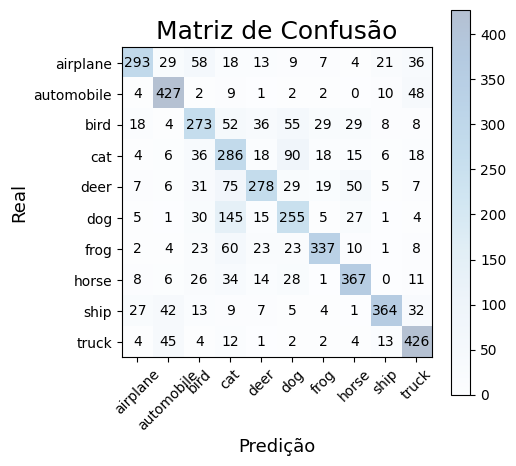

In [69]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3, interpolation = 'nearest')
plt.gca().xaxis.tick_bottom()

tick_marks = np.arange(len(cifar10_classes))
plt.xticks(tick_marks, cifar10_classes, rotation=45)
plt.yticks(tick_marks, cifar10_classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

fig.colorbar(cax)

plt.xlabel('Predição', fontsize=13)
plt.ylabel('Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

In [60]:
'''

model_dir = "./trained_models/"
create_directory(model_dir)

# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

model_name = 'trained_model_deep_learning' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

'''

'\n\nmodel_dir = "./trained_models/"\ncreate_directory(model_dir)\n\n# obtendo a data e hora atual\nnow = datetime.now()\n\n# Definição do formato\nformat = \'%Y-%m-%dT%H%M\'\n\n# Converter a data e hora em uma string com o formato especificado\nformatted_datetime = now.strftime(format)\n\nmodel_name = \'trained_model_deep_learning\' + formatted_datetime + \'.h5\'\n\n# salvando o modelo\nmodel.save("%s/%s" % (model_dir, model_name))\nprint("Modelo salvo com o nome: ", model_name)\n\n'

In [61]:
'''

model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

'''

'\n\nmodel_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))\nprint("Modelo %s carregado com sucesso" % (model_name))\n\n'

In [62]:
'''

test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1:
        break

    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model_loaded.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]

            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]

            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            # class_name = 'dog' if prediction >= 0.5 else 'cat'

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)

'''

"\n\ntest_generator.reset()\n\ncount = 0\ny_pred = list()\ny_true = list()\nclass_names = cifar10_classes\n\n# Loop do data generator de teste que contem as imagens\nfor batch in test_generator:\n\n    count+=1\n\n    # Condição de saída do loop. Só executaremos o modelo em algumas imagens\n    if count == len(test_generator)+1:\n        break\n\n    else:\n        # Pegando a imagem e o label\n        images = batch[0]\n        labels = batch[1]\n\n        # Previsão\n        predictions = model_loaded.predict(images)\n\n        # Visualização da imagem\n        for i in range(len(images)):\n\n            image = images[i]\n            label = labels[i]\n\n            prediction = predictions[i]\n\n            # Converte o array de previsão para visualizar a classe e a probabilidade\n            predicted_class = np.argmax(prediction)\n            probability = prediction[predicted_class]\n\n            labeled_class = np.argmax(label)\n            label = class_names[int(labeled_clas

In [63]:
'''

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning_trained.csv",index=False)

'''

'\n\nfilenames=test_generator.filenames\nresults=pd.DataFrame({"Filename":filenames,\n                      "Predictions":y_pred})\nresults.to_csv("results_deep_learning_trained.csv",index=False)\n\n'